In [1]:
import tensorflow as tf

# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

2024-03-19 18:37:03.480477: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-19 18:37:03.484503: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-19 18:37:03.535074: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 18:37:04.702483: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir



In [3]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMG_SIZE = (224, 224)
train_data_10_percent = image_dataset_from_directory(train_dir,
													 image_size=IMG_SIZE,
													 label_mode="categorical")

test_data = image_dataset_from_directory(test_dir,
										image_size=IMG_SIZE,
										label_mode="categorical")


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
train_data_10_percent, train_data_10_percent.class_names

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 ['chicken_curry',
  'chicken_wings',
  'fried_rice',
  'grilled_salmon',
  'hamburger',
  'ice_cream',
  'pizza',
  'ramen',
  'steak',
  'sushi'])

In [6]:
for images, labels in train_data_10_percent.take(1):
	print(images, labels)

tf.Tensor(
[[[[1.93093277e+02 1.65989639e+02 1.57041458e+02]
   [1.94704727e+02 1.67559631e+02 1.56559631e+02]
   [2.00427139e+02 1.70442276e+02 1.56770569e+02]
   ...
   [2.38419647e+02 1.47477524e+02 1.54234314e+02]
   [2.31011719e+02 1.59002899e+02 1.59933670e+02]
   [2.20871841e+02 1.62626938e+02 1.58508118e+02]]

  [[1.94233582e+02 1.65804214e+02 1.57441162e+02]
   [1.99727676e+02 1.70857147e+02 1.60292419e+02]
   [2.03878983e+02 1.71692444e+02 1.58785721e+02]
   ...
   [2.34564728e+02 1.41595139e+02 1.49365677e+02]
   [2.27341156e+02 1.49238892e+02 1.51926193e+02]
   [2.24570496e+02 1.58407837e+02 1.57154755e+02]]

  [[1.97901779e+02 1.65901947e+02 1.57694672e+02]
   [2.00183517e+02 1.68680801e+02 1.58058990e+02]
   [2.03015457e+02 1.69136002e+02 1.56609375e+02]
   ...
   [2.33533691e+02 1.38536621e+02 1.46750885e+02]
   [2.28981628e+02 1.42228500e+02 1.47588333e+02]
   [2.27796982e+02 1.48738647e+02 1.51816925e+02]]

  ...

  [[1.59635849e+02 8.66358490e+01 7.90867767e+01]
   [1

2024-03-19 18:37:07.049849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="nput_layer")

# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.0)(inputs)

x = base_model(inputs)
print(f"shape aer inputs: {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"shape after global pool: {x.shape}")

outputs = tf.keras.layers.Dense(10, activation="softmax", name="out_layer")(x)
print(f"shape after global pool: {x.shape}")

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(
	optimizer=tf.keras.optimizers.Adam(),
	loss="categorical_crossentropy",
	metrics=["accuracy"]
)

history_0 = model_0.fit(train_data_10_percent,
						validation_data=test_data,
						validation_steps=len(test_data) // 4,
						epochs=5,
						steps_per_epoch=len(test_data),
						callbacks=[create_tensorboard_callback(
							dir_name="transfer_learning", 
							experiment_name="10_percent")])

shape aer inputs: (None, 7, 7, 1280)
shape after global pool: (None, 1280)
shape after global pool: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent/20240319-183708
Epoch 1/5
24/79 ━━━━━━━━━━━━━━━━━━━━ 34s 635ms/step - accuracy: 0.2245 - loss: 2.1702

2024-03-19 18:37:33.876798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 364ms/step - accuracy: 0.3207 - loss: 1.9384 - val_accuracy: 0.7171 - val_loss: 1.3442
Epoch 2/5
24/79 ━━━━━━━━━━━━━━━━━━━━ 32s 586ms/step - accuracy: 0.7016 - loss: 1.2624

2024-03-19 18:38:01.996334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 326ms/step - accuracy: 0.7172 - loss: 1.1601 - val_accuracy: 0.7845 - val_loss: 0.9098
Epoch 3/5
24/79 ━━━━━━━━━━━━━━━━━━━━ 33s 603ms/step - accuracy: 0.7934 - loss: 0.9123

2024-03-19 18:38:28.530718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 331ms/step - accuracy: 0.7989 - loss: 0.8572 - val_accuracy: 0.8339 - val_loss: 0.7362
Epoch 4/5
24/79 ━━━━━━━━━━━━━━━━━━━━ 36s 667ms/step - accuracy: 0.8211 - loss: 0.7144

2024-03-19 18:38:56.530306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 367ms/step - accuracy: 0.8315 - loss: 0.6799 - val_accuracy: 0.8388 - val_loss: 0.6570
Epoch 5/5
24/79 ━━━━━━━━━━━━━━━━━━━━ 34s 630ms/step - accuracy: 0.8795 - loss: 0.5771

2024-03-19 18:39:25.078946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - accuracy: 0.8743 - loss: 0.5670 - val_accuracy: 0.8088 - val_loss: 0.4399


2024-03-19 18:39:26.374484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [8]:
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 52s 661ms/step - accuracy: 0.8590 - loss: 0.5582


[0.5748628973960876, 0.8519999980926514]

In [9]:
for layer_number, layer in enumerate(base_model.layers):
	print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [10]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          0 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

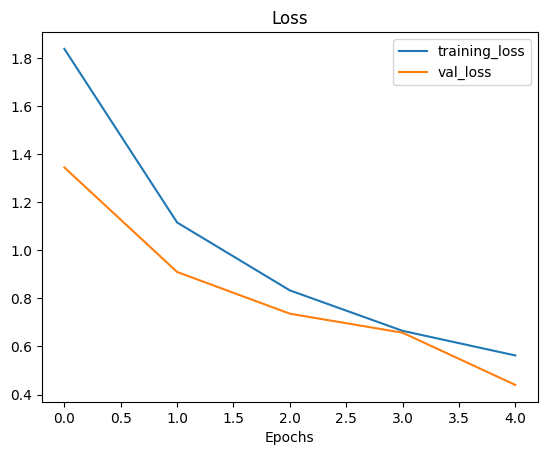

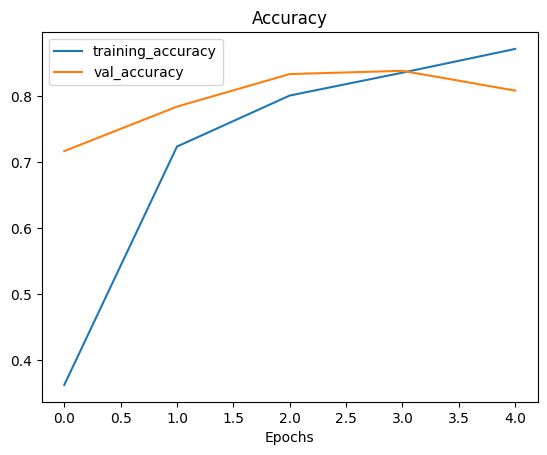

In [11]:
plot_loss_curves(history_0)

In [12]:
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
# print(input_tensor)

global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(global_average_pooled_tensor)

tf.Tensor([[-0.09368646 -0.45840445 -0.28855976]], shape=(1, 3), dtype=float32)


In [13]:
unzip_data("10_food_classes_1_percent.zip")

train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [14]:
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
	train_dir_1_percent,
	label_mode="categorical",
	image_size=IMG_SIZE,
	batch_size=32
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
	test_dir,
	label_mode="categorical",
	image_size=IMG_SIZE,
	batch_size=32
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [15]:
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
	layers.RandomFlip("horizontal"),
	layers.RandomRotation(0.2),
	layers.RandomZoom(0.2),
	layers.RandomHeight(0.2),
	layers.RandomWidth(0.2),
	layers.Rescaling(1.0/255),
], name="data_augmentation")

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'Rescale'